# Attention, l'éxecution de tous le notebook est très longue. 

## Installation des packages et importation des données

In [53]:
# !pip install MTCFeatures # A executer une seule fois

In [2]:
import MTCFeatures
from MTCFeatures import MTCFeatureLoader
import pandas as pd

In [55]:
# MTCFeatures.downloadData(dest='user') # A executer une seule fois

In [3]:
fl = MTCFeatureLoader('MTC-FS-INST-2.0')
seqs = fl.sequences()

In [4]:
%%time
phrase_data = []
for ii, x in enumerate(seqs):
    phrase_data.append({
        'id': x['id'],
        **x['features']
    })

EOFError: Compressed file ended before the end-of-stream marker was reached

## On commence par étudier les données

In [6]:
df_phrase = pd.DataFrame(phrase_data)
df_phrase.shape # (13492, 62)

(13492, 62)

Notre dataset contient 13492 séquences et 62 attributs

In [7]:
import numpy as np

La cellule suivante est une première découverte des features et de leur format. Nous avons pu en déduire quelques idées pour la suite du traitement des données

In [60]:
# Chaque ligne du set représente une mélodie, représentée par des features.

print(np.array(df_phrase['pitch'][0]).shape) # pitch représente la hauteur des notes
print(np.array(df_phrase['duration'][0]).shape) # duration représente la durée des notes
print(np.array(df_phrase['phrase_end'][0]).shape) # phrase_end dit si la note est la dernière de la phrase

print(df_phrase['pitch'][0])
print(df_phrase['duration'][0])
print(df_phrase['phrase_end'][0])
# On peut donc voir que chacune de ses 3 features est une liste de la même longueur que le nombre de notes dans la mélodie.

# combien de fin de phrase dans le premier exemple ?

print(np.sum(df_phrase['phrase_end'][0])) # 4

# On pense découper les séquences en sous séquences par notes avec un nombre fixe de notes par sous séquence.

print(df_phrase['beat'][0]) # beat représente le temps de la note dans la mesure

# On peut aussi faire des sous séquences basées sur les mesures pour éviter de couper une mesure en deux.

print(df_phrase['beat_fraction_str'][0]) # beat_fraction_str représente le temps de la note dans la mesure sous forme de fraction


(44,)
(44,)
(44,)
['E4', 'C4', 'A3', 'G3', 'C4', 'C4', 'D4', 'C4', 'D4', 'E4', 'A3', 'G3', 'G3', 'F#3', 'G3', 'A3', 'F4', 'E4', 'D4', 'E4', 'D4', 'G3', 'D4', 'E4', 'D4', 'C4', 'A3', 'G3', 'E4', 'F4', 'E4', 'A3', 'E4', 'D4', 'G3', 'A3', 'G3', 'G3', 'F4', 'E4', 'D4', 'A3', 'B3', 'C4']
[1.0, 0.5, 0.5, 0.75, 0.25, 1.0, 1.0, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 0.5, 0.5, 1.0, 1.0, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 0.5, 0.5, 1.5]
[False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, True]
4
[1.0, 2.0, 2.5, 1.0, 1.75, 2.0, 1.0, 2.0, 2.5, 1.0, 1.5, 2.0, 1.0, 2.0, 2.5, 1.0, 1.5, 2.0, 1.0, 2.0, 2.5, 1.0, 1.0, 2.0, 2.5, 1.0, 1.5, 2.0, 1.0, 2.0, 2.5, 1.0, 1.5, 2.0, 1.0, 2.0, 2.5,

In [61]:
# print(df_phrase.describe()) # Pas utile pour les features qui sont des listes et trop long, la méthode describe() ne sert pas ici

In [62]:
df_phrase.info() # 7302 sequences avec paroles

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13492 entries, 0 to 13491
Data columns (total 62 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     13492 non-null  object
 1   scaledegree            13492 non-null  object
 2   scaledegreespecifier   13492 non-null  object
 3   tonic                  13492 non-null  object
 4   mode                   13492 non-null  object
 5   metriccontour          13492 non-null  object
 6   imaweight              13492 non-null  object
 7   pitch40                13492 non-null  object
 8   midipitch              13492 non-null  object
 9   diatonicpitch          13492 non-null  object
 10  diatonicinterval       13492 non-null  object
 11  chromaticinterval      13492 non-null  object
 12  pitchproximity         13492 non-null  object
 13  pitchreversal          13492 non-null  object
 14  nextisrest             13492 non-null  object
 15  restduration_frac  

In [63]:
for col in df_phrase.columns:
    t = type(df_phrase[col][0])
    if t != list:
        print(col, t)

# On cherche les colonnes qui ne sont pas des listes

id <class 'str'>
lyrics <class 'float'>
noncontentword <class 'float'>
wordend <class 'float'>
phoneme <class 'float'>
rhymes <class 'float'>
rhymescontentwords <class 'float'>
wordstress <class 'float'>
melismastate <class 'float'>


```
id <class 'str'>
lyrics <class 'float'>
noncontentword <class 'float'>
wordend <class 'float'>
phoneme <class 'float'>
rhymes <class 'float'>
rhymescontentwords <class 'float'>
wordstress <class 'float'>
melismastate <class 'float'>
```

Ces attributs ne sont pas utiles car pour chaque sous séquence d'une séquence ils seront les même et donc n'apportent pas d'information sur une fin de phrase étant donnée que se ne sont pas des tableaux comme les autres.

On remarque qu'il y a 7302 séquences avec des paroles

In [8]:
def generate_subsequences(df, length=8, reverse=False):
    """
    Divise les colonnes de type liste d'un DataFrame en sous-séquences de taille `length`,
    en excluant les sous-séquences dont la longueur est inférieure à `length`.

    Args:
        df (pd.DataFrame): Le DataFrame d'entrée contenant des colonnes avec des listes.
        length (int): La longueur des sous-séquences souhaitées.
        reverse (bool): true si l'on veut commencer le découpage par la fin de la séquence

    Returns:
        pd.DataFrame: Un nouveau DataFrame contenant les sous-séquences comme lignes.
    """
    subsequences = []

    #on itere sur toutes les lignes de notre dataframe (donc sur chaque séquence)
    for _, row in df.iterrows():

        # dans les valeurs pour chaque attribut, on récupère la liste de taille minimale de notre séquence actuelle

        min_length = min(len(row[col]) for col in df.columns) # Normalement pas utile car toutes les features ont la même longueure pour une séquence.

        if not reverse:
            # on prend portion par portion de notes ( longueur length ) pour diviser notre séquence
            for start_idx in range(0, min_length, length):
                # pour chaque portion de notes on créé notre sous séquence en reprenant les valeurs pour chaque attributs mais 
                # aux indices de la portion de notes courrants
                subsequence = {
                    col: row[col][start_idx:start_idx + length]
                    for col in df.columns
                }
                # si toutes les valeurs sont complétées et si la longueur des sous séquences est égale à length, on peut ajouter la sous séquence à notre liste de sous sequences
                if all(len(subsequence[col]) == length for col in df.columns):
                    subsequences.append(subsequence)

        else:
            for start_idx in range(min_length, 0, -length):
                subsequence = {
                    col: row[col][start_idx - length:start_idx]
                    for col in df.columns
                }
                if all(len(subsequence[col]) == length for col in df.columns):
                    subsequences.append(subsequence)

    # on en créé un dataframe
    return pd.DataFrame(subsequences)

#### La cellule du dessous montre un test pour voir toutes les valeurs possibles dans les listes d'une colone. Value_counts() ne fonctionne pas car les attributs sont des listes.

In [65]:
# toutes les valeurs possibles de la colonne 'timesignature' dans le DataFrame
timesignature = []
for x in df_phrase['timesignature']:
    for y in x:
        if y not in timesignature:
            timesignature.append(y)
print(timesignature)

['2/4', '4/4', '6/8', '3/4', '3/8', '5/8', '7/8', '2/2', '12/8', '8/16', None, '6/4', '3/2', '3/16', '9/8', '9/4', '4/2', '5/4', '4/8', '8/8', '10/8', '2/8', '1/4', '7/4', '22/8', '2/16', '8/4', '13/8', '19/16', '6/2', '1/2', '2/1', '10/4', '10/2', '12/2', '16/2', '5/2']


on peut le faire pour chaque attribut pour voir toutes les valeurs possibles. Cela va nous être utile pour transformer les listes de valeurs non numériques en listes de valeurs numériques.

## On continue d'analyser les données

In [66]:
i = 1
j = 0

print("midipitch:", df_phrase['midipitch'][i][j:j+8])
print("diatonicpitch",  df_phrase['diatonicpitch'][i][j:j+8])
print("chromaticinterval:", df_phrase['chromaticinterval'][i][j:j+8])
print("tonic:", df_phrase['tonic'][i][j:j+8])
print("mode:", df_phrase['mode'][i][j:j+8])

# print("scaledegree:", df_phrase['scaledegree'][i][j:j+8])
print("timesignature:", df_phrase['timesignature'][i][j:j+8])
print("beatstrength:", df_phrase['beatstrength'][i][j:j+8])
# print("metriccontour:", df_phrase['metriccontour'][i][j:j+8])
# print("imaweight:", df_phrase['imaweight'][i][j:j+8])
# print("imacontour:", df_phrase['imacontour'][i][j:j+8])
print("=====================================")
print("duration:", df_phrase['duration'][i][j:j+8])
# print("duration_frac:", df_phrase['duration_frac'][i][j:j+8])
# print("duration_fullname:", df_phrase['duration_fullname'][i][j:j+8])
print("durationcontour:", df_phrase['durationcontour'][i][j:j+8])
print("IOI:", df_phrase['IOI'][i][j:j+8])
print("IOR:", df_phrase['IOR'][i][j:j+8])
# print("onsettick:", df_phrase['onsettick'][i][j:j+8]) # onsettick représente le temps de la note en ticks mais ne sert pas dans notre cas car ne donne aucune information utiles, comme un ID

print("=====================================")
print("beatfraction:", df_phrase['beatfraction'][i][j:j+8]) # durée de la note
print("beat_str:", df_phrase['beat_str'][i][j:j+8])
print("beat_fraction_str:", df_phrase['beat_fraction_str'][i][j:j+8])
print("beat:", df_phrase['beat'][i][j:j+8]) # beat_str + beat_fraction_str
# print("songpos:", df_phrase['songpos'][i][j:j+8]) # position de la note dans la chanson similaire à onsettick

print("=====================================")
# print("beatinsong:", df_phrase['beatinsong'][i][j:j+8]) # meme chose que pour songpos et onsettick
# print("nextisrest:", df_phrase['nextisrest'][i][j:j+8])
print("restduration_frac:", df_phrase['restduration_frac'][i][j:j+8]) # plus précis que nextisrest
print("phrase_ix:", df_phrase['phrase_ix'][i][j:j+8]) #numero de la phrase, inutile (id)
print("=====================================")
print("phrasepos", df_phrase['phrasepos'][i][j:j+8]) # position de la note dans la phrase
print("phrase_end", df_phrase['phrase_end'][i][j:j+8]) # indique si la note est la fin de la phrase
print("=====================================")
print("beatinphrase", df_phrase['beatinphrase'][i][j:j+8])
print("beatinphrase_end", df_phrase['beatinphrase_end'][i][j:j+8])
print("=====================================")
print("melismastate", df_phrase['melismastate'][i])

midipitch: [72, 73, 74, 72, 70, 69, 65, 69]
diatonicpitch [32, 32, 33, 32, 31, 30, 28, 30]
chromaticinterval: [None, 1, 1, -2, -2, -1, -4, 4]
tonic: ['F', 'F', 'F', 'F', 'F', 'F', 'F', 'F']
mode: ['major', 'major', 'major', 'major', 'major', 'major', 'major', 'major']
timesignature: ['4/4', '4/4', '4/4', '4/4', '4/4', '4/4', '4/4', '4/4']
beatstrength: [0.25, 0.0625, 1.0, 0.25, 0.5, 0.25, 1.0, 0.125]
duration: [0.75, 0.25, 1.0, 1.0, 1.0, 1.0, 0.5, 0.25]
durationcontour: [None, '-', '+', '=', '=', '=', '-', '-']
IOI: [0.75, 0.25, 1.0, 1.0, 1.0, 1.0, 0.5, 0.25]
IOR: [None, 0.3333333333333333, 4.0, 1.0, 1.0, 1.0, 0.5, 0.5]
beatfraction: ['3/4', '1/4', '1', '1', '1', '1', '1/2', '1/4']
beat_str: ['4', '4', '1', '2', '3', '4', '1', '1']
beat_fraction_str: ['0', '3/4', '0', '0', '0', '0', '0', '1/2']
beat: [4.0, 4.75, 1.0, 2.0, 3.0, 4.0, 1.0, 1.5]
restduration_frac: [None, None, None, None, None, None, None, None]
phrase_ix: [0, 0, 0, 0, 0, 0, 0, 0]
phrasepos [0.0, 0.107143, 0.142857, 0.2857

Les attributs phrasepos et phrase_end donnent explicitement une indication sur la fin de phrase. beatinphrase et beatinphrase_end donnent également des indications explicites sur le début et la fin des phrases. 

on remarque qu'il y a des features qui sont équivalentes comme le `pitch` et le `midipitch`. Ce dernier n'est qu'une représentation du premier en midi, c'est-à-dire en entier. On pourra donc omettre le pitch et ne garder que le midipitch car il est plus simple à manipuler et donne plus d'informations que le `diatonicpitch`.

pour `pitch` (valeurs en chaine de caractères) et `midipitch` (valeurs numériques) :
on a C5 = 72 et C#5 = 73 car c'est la note juste après C5

pour `diatonicpitch` et `midipitch` :
pour les deux note suivantes : C5 et C#5 on aura alors la même valeur : 32. On perd donc de l'information.

On doit chercher toutes les features qui sont corrélées pour ne pas utiliser des features inutiles.

# liste des features corrélées selon la documentation de MTCFeatures : 

[`pitch`, `midipitch`, `pitch40`, `diatonicpitch`] -> `midipitch` : hauteur de la note

[`contour3`, `contour5`, `diatonicinterval`, `chromaticinterval`] -> `chromaticinterval` : variation par rapport à la note précédente

[`tonic`] -> `tonic`

[`mode`] -> `mode`

[`scaledegree`, `scaledegreespecifier`] -> `scaledegree` : peut-être les 2 ?

[`timesignature`] -> `timesignature`

[`beatstrength`] -> `beatstrength`

[`mtriccontour`] -> `metriccontour`

[`imaweight`] -> `imaweight`

[`imacontour`] -> `imacontour`

[`duration`, `duration_frac`, `duration_fullname`] -> `duration` : durée de la note (forme de fraction et nom chaine de caractère)

[`durationcontour`] -> `durationcontour`

[`IOI`, `IOI_frac`] -> `IOI`

[`IOR`, `IOR_frac`] -> `IOR` : ratio entre IOI précédent et IOI actuel

[`beatfraction`] -> `beatfraction` : durée de la note

[`beat_fraction_str`, `beat_str`, `beat`] -> `beat` : `beat_fraction_str` + `beat_str`

[`nextisrest`, `restduration_frac`] -> `restduration_frac` : pause qui suit la note

[`phrasepos`, `phrase_end`] -> `phrase_pos` : fin de la phrase

[`beatinphrase`, `beatinphrase_end`] -> les deux sont similaires, donne info sur fin de phrase donc peut être à ne pas prendre en compte


[`onsettick`, `songpos`, `beatinsong`, `phrase_ix`] -> aucune features utile

Les autres features ne sont pas utiles car ...












# premiere selection des features

In [9]:
features = np.array(['midipitch', 'chromaticinterval', 'scaledegree', 'timesignature', 'beatstrength', 'metriccontour', 'imaweight', 'imacontour', 'duration', 'durationcontour', 'beatfraction', 'beat', 'restduration_frac', 'phrase_end'])
new_df = df_phrase[features]

mode et tonic ont été retirées après coup car ces attributs créaient trop de valeur en plus à passer en entrée de notre modèle pour aucune information sur les fins de phrase

# On découpe notre dataset en sous sequences de 8 notes

In [10]:
sub_seqs_df = generate_subsequences(new_df, length=8)

sub_seqs_df.head()

,midipitch,chromaticinterval,scaledegree,timesignature,beatstrength,metriccontour,imaweight,imacontour,duration,durationcontour,beatfraction,beat,restduration_frac,phrase_end
0,"[64, 60, 57, 55, 60, 60, 62, 60]","[None, -4, -3, -2, 5, 0, 2, -2]","[3, 1, 6, 5, 1, 1, 2, 1]","[2/4, 2/4, 2/4, 2/4, 2/4, 2/4, 2/4, 2/4]","[1.0, 0.5, 0.25, 1.0, 0.125, 0.5, 1.0, 0.5]","[None, -, -, +, -, +, +, -]","[0.798013, 0.663907, 0.150662, 0.945364, 0.013...","[None, -, -, +, -, +, +, -]","[1.0, 0.5, 0.5, 0.75, 0.25, 1.0, 1.0, 0.5]","[None, -, =, +, -, +, =, -]","[1, 1/2, 1/2, 3/4, 1/4, 1, 1, 1/2]","[1.0, 2.0, 2.5, 1.0, 1.75, 2.0, 1.0, 2.0]","[None, None, None, None, None, None, None, None]","[False, False, False, False, False, False, Fal..."
1,"[62, 64, 57, 55, 55, 54, 55, 57]","[2, 2, -7, -2, 0, -1, 1, 2]","[2, 3, 6, 5, 5, 4, 5, 6]","[2/4, 2/4, 2/4, 2/4, 2/4, 2/4, 2/4, 2/4]","[0.25, 1.0, 0.25, 0.5, 1.0, 0.5, 0.25, 1.0]","[-, +, -, +, +, -, -, +]","[0.195364, 0.812914, 0.162252, 0.627483, 0.951...","[-, +, -, +, +, -, -, +]","[0.5, 0.5, 0.5, 1.0, 1.0, 0.5, 0.5, 0.5]","[=, =, =, +, =, -, =, =]","[1/2, 1/2, 1/2, 1, 1, 1/2, 1/2, 1/2]","[2.5, 1.0, 1.5, 2.0, 1.0, 2.0, 2.5, 1.0]","[None, None, None, None, None, None, None, None]","[False, False, False, True, False, False, Fals..."
2,"[65, 64, 62, 64, 62, 55, 62, 64]","[8, -1, -2, 2, -2, -7, 7, 2]","[4, 3, 2, 3, 2, 5, 2, 3]","[2/4, 2/4, 2/4, 2/4, 2/4, 2/4, 2/4, 2/4]","[0.25, 0.5, 1.0, 0.5, 0.25, 1.0, 1.0, 0.5]","[-, +, +, -, -, +, =, -]","[0.183775, 0.642384, 0.837748, 0.692053, 0.25,...","[-, +, +, -, -, +, -, -]","[0.5, 1.0, 1.0, 0.5, 0.5, 1.0, 1.0, 0.5]","[=, +, =, -, =, +, =, -]","[1/2, 1, 1, 1/2, 1/2, 1, 1, 1/2]","[1.5, 2.0, 1.0, 2.0, 2.5, 1.0, 1.0, 2.0]","[None, None, None, None, None, 1, None, None]","[False, False, False, False, False, True, Fals..."
3,"[62, 60, 57, 55, 64, 65, 64, 57]","[-2, -2, -3, -2, 9, 1, -1, -7]","[2, 1, 6, 5, 3, 4, 3, 6]","[2/4, 2/4, 2/4, 2/4, 2/4, 2/4, 2/4, 2/4]","[0.25, 1.0, 0.25, 0.5, 1.0, 0.5, 0.25, 1.0]","[-, +, -, +, +, -, -, +]","[0.243377, 0.870861, 0.205298, 0.630795, 0.917...","[-, +, -, +, +, -, -, +]","[0.5, 0.5, 0.5, 1.0, 1.0, 0.5, 0.5, 0.5]","[=, =, =, +, =, -, =, =]","[1/2, 1/2, 1/2, 1, 1, 1/2, 1/2, 1/2]","[2.5, 1.0, 1.5, 2.0, 1.0, 2.0, 2.5, 1.0]","[None, None, None, None, None, None, None, None]","[False, False, False, False, False, False, Fal..."
4,"[64, 62, 55, 57, 55, 55, 65, 64]","[7, -2, -7, 2, -2, 0, 10, -1]","[3, 2, 5, 6, 5, 5, 4, 3]","[2/4, 2/4, 2/4, 2/4, 2/4, 2/4, 2/4, 2/4]","[0.25, 0.5, 1.0, 0.5, 0.25, 1.0, 0.25, 0.5]","[-, +, +, -, -, +, -, +]","[0.162252, 0.652318, 0.84106, 0.652318, 0.1837...","[-, +, +, -, -, +, -, +]","[0.5, 1.0, 1.0, 0.5, 0.5, 0.5, 0.5, 1.0]","[=, +, =, -, =, =, =, +]","[1/2, 1, 1, 1/2, 1/2, 1/2, 1/2, 1]","[1.5, 2.0, 1.0, 2.0, 2.5, 1.0, 1.5, 2.0]","[None, None, None, None, None, None, None, None]","[False, True, False, False, False, False, Fals..."


## Certaines features ne sont pas des listes de valeur mais des strings. On va les transformer en valeur numérique :

In [78]:
from sklearn.preprocessing import OneHotEncoder
from fractions import Fraction

def transform_features(df):
    """
    Transforme les features qui ne sont pas des listes de nombres en listes de nombres.

    Transformations spécifiques :
    - 'chromaticinterval': remplace None par 0.
    - 'tonic': encode les valeurs en vecteurs binaires selon 21 possibilités.
    - 'mode': encode les valeurs en vecteurs binaires selon 6 possibilités.
    - 'timesignature': convertit les fractions en nombres décimaux.
    - 'beatfraction': convertit les fractions en nombres décimaux.
    - 'metriccontour', 'imacontour', 'durationcontour': transforme les chaînes en 1, -1 ou 0.
    - 'restduration_frac': convertit les fractions en nombres décimaux, remplace None par 0.0.

    Args:
        df (pd.DataFrame): Le DataFrame d'entrée.

    Returns:
        pd.DataFrame: Le DataFrame transformé.
    """
    if 'chromaticinterval' in df.columns:
        # print("chromaticinterval")
        df['chromaticinterval'] = df['chromaticinterval'].apply(
            lambda lst: [0 if val is None else val for val in lst]
        )

    if 'beatstrength' in df.columns:
        # print("beatstrength")
        df['beatstrength'] = df['beatstrength'].apply(
            lambda lst: [0 if val is None else val for val in lst]
        )

    if 'beat' in df.columns:
        # print("beat")
        df['beat'] = df['beat'].apply(
            lambda lst: [0 if val is None else val for val in lst]
        )

    if 'tonic' in df.columns:
        # print("tonic")
        notes = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
        alterations = ['-', '', '#']
        possible_tonics = [n + a for n in notes for a in alterations]
        encoder = OneHotEncoder(categories=[possible_tonics], sparse_output=False, handle_unknown='ignore')

        def encode_tonic(tonic_list):
            encoded = encoder.fit_transform(np.array(tonic_list).reshape(-1, 1))
            return encoded.tolist()

        df['tonic'] = df['tonic'].apply(encode_tonic)

    if 'mode' in df.columns:
        # print("mode")
        possible_modes = ['major', 'minor', 'dorian', 'phrygian', 'lydian', 'mixolydian']
        encoder = OneHotEncoder(categories=[possible_modes], sparse_output=False, handle_unknown='ignore')

        def encode_mode(mode_list):
            encoded = encoder.fit_transform(np.array(mode_list).reshape(-1, 1))
            return encoded.tolist()

        df['mode'] = df['mode'].apply(encode_mode)

    if 'timesignature' in df.columns:
        # print("timesignature")
        df['timesignature'] = df['timesignature'].apply(
            lambda lst: [float(Fraction(val)) if val is not None else 0.0 for val in lst]
        )

    if 'beatfraction' in df.columns:
        # print("beatfraction")
        df['beatfraction'] = df['beatfraction'].apply(
            lambda lst: [float(Fraction(val)) if val is not None else 0.0 for val in lst]
        )

    def transform_contour(contour_list):
        return [
            1 if val == '+' else -1 if val == '-' else 0 if val in ('=', None) else val
            for val in contour_list
        ]

    for contour_feature in ['metriccontour', 'imacontour', 'durationcontour']:
        if contour_feature in df.columns:
            # print(contour_feature)
            df[contour_feature] = df[contour_feature].apply(transform_contour)

    if 'restduration_frac' in df.columns:
        # print("restduration_frac")
        df['restduration_frac'] = df['restduration_frac'].apply(
            lambda lst: [float(Fraction(val)) if val is not None else 0.0 for val in lst]
        )

    def transform_att(att_list):
        if isinstance(att_list, list):
            return [0 if val is None else val for val in att_list]
        return att_list

    for att in ['gpr2a_Frankland', 'gpr2b_Frankland', 'gpr3a_Frankland', 'gpr3d_Frankland', 'lbdm_boundarystrength', 'lbdm_spitch', 'lbdm_sioi', 'lbdm_srest', 'lbdm_rpitch', 'lbdm_rioi', 'lbdm_rrest', 'pitchproximity', 'pitchreversal']:
        if att in df.columns:
            print(f"Column: {att}")
            df[att] = df[att].apply(transform_att)

    return df

## Il faut également étiqueter les données de notre dataset d'apprentissage :

In [12]:
# trois types d'etiquettages possibles :

def transform_target_any(df): # on regarde si il y a une fin de phrase dans la sous séquence
    """
    Transforme la colonne 'phrase_end' en une seule valeur binaire. 1 si il y a une fin de phrase dans la sous séquence
    """
    if 'phrase_end' in df.columns:
        # print("phrase_end")
        df['phrase_end'] = df['phrase_end'].apply(
            lambda lst: 1 if any(val == True for val in lst) else 0
        )

    return df

def transform_target_end(df): # on regarde si la fin de phrase est à la fin de la sous séquence
    """
    Transforme la colonne 'phrase_end' en une seule valeur binaire. 1 si il y a une fin de phrase à la fin de la séquence
    """
    if 'phrase_end' in df.columns:
        df['phrase_end'] = df['phrase_end'].apply(
            lambda lst: 1 if lst[-1] == True else 0
        )

    return df

def transform_target_hybrid(df, idx):
    """
    Transforme la colonne 'phrase_end' en une seule valeur binaire. 1 si il y a une fin de phrase à partir de l'indice idx
    """
    idx = len(df['phrase_end'][0]) - idx
    if 'phrase_end' in df.columns:
        df['phrase_end'] = df['phrase_end'].apply(
            lambda lst: 1 if True in lst[idx:] else 0
        )

    return df

## premier test de modèle

surtout pour voir si les features sont bien traitées et transformées en tableaux de valeurs numériques

In [55]:
transformed_sub_seqs_df = transform_features(sub_seqs_df)
transformed_sub_seqs_df1 = transformed_sub_seqs_df.copy()
transformed_sub_seqs_df1 = transform_target_any(transformed_sub_seqs_df1)

On va alors prendre les moyennes, écarts type, minimum et maximum pour chaque features. Cela n'a pas vraiment de sens mais c'est pour voir si nos données sont bien transformée et pour avoir un prmier apperçu

In [22]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

# Exemple : Fonction de transformation pour des données séquentielles
def transform_sequence_features(df, sequence_columns):
    """
    Transforme des colonnes contenant des listes ou vecteursùm  en statistiques globales.
    """
    transformed_features = {}
    for col in sequence_columns:
        transformed_features[f'{col}_mean'] = df[col].apply(np.mean)
        transformed_features[f'{col}_std'] = df[col].apply(np.std)
        transformed_features[f'{col}_min'] = df[col].apply(np.min)
        transformed_features[f'{col}_max'] = df[col].apply(np.max)
    return pd.DataFrame(transformed_features)

# Étape 1 : Charger les données
sequence_columns = ['midipitch', 'chromaticinterval', 'scaledegree', 
                    'beatstrength', 'metriccontour', 'duration']
target_column = 'phrase_end'

# Transformer les données
transformed_df = transform_sequence_features(transformed_sub_seqs_df1, sequence_columns)
transformed_df
transformed_df['phrase_end'] = transformed_sub_seqs_df1[target_column]

# Séparer les données en X et y
X = transformed_df.drop(columns=['phrase_end'])
y = transformed_df['phrase_end']

# Diviser en jeu d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Étape 2 : Tester plusieurs modèles
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100),
}

# Étape 3 : Entraîner et évaluer chaque modèle
for name, model in models.items():
    pipeline = Pipeline([
        ('model', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    print(f"{name}:")
    print(classification_report(y_test, y_pred))
    print("-" * 30)


In [73]:
# print(models['Random Forest'].score(X_test, y_test))

## comme on a des liste de features, on va les aplatir pour pouvoir les utiliser dans un modèle

cela sera plus pertinant que de prendre la moyenne ou l'écart type. On pourra capturer les variations entre chaque note

In [14]:
import pandas as pd

def flatten_row(row):
    flattened = {}
    for attr, values in row.items():
        if isinstance(values, list):  # Si la valeur est une liste (comme mode ou tonic, mais on ne les utilise pas)
            for i, val in enumerate(values):
                flattened[f"{attr}_{i}"] = val
        else:
            flattened[attr] = values  # Si ce n'est pas une liste
    return flattened

def flatten_dataframe(data):
    flattened_rows = [flatten_row(row) for _, row in data.iterrows()]
    return pd.DataFrame(flattened_rows)



In [56]:

transformed_sub_seqs_df_flattened1 = flatten_dataframe(transformed_sub_seqs_df1.drop(columns=['phrase_end']))
transformed_sub_seqs_df_flattened1['phrase_end'] = transformed_sub_seqs_df1['phrase_end']


In [76]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")


X = transformed_sub_seqs_df_flattened1.drop(columns=['phrase_end'])
y = transformed_sub_seqs_df_flattened1['phrase_end']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    # 'SVM': SVC(),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'KNN': KNeighborsClassifier(),
    'MLP' : MLPClassifier(),
}

for name, model in models.items():
    print(name)
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    # scores = cross_val_score(pipeline, X_train, y_train, cv=5)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    print(f"{name}:")
    # print(f"Cross-validation scores: {scores}")
    # print(f"Mean cross-validation score: {scores.mean()}")
    print(classification_report(y_test, y_pred))
    print("-" * 30)

Logistic Regression
Logistic Regression:
              precision    recall  f1-score   support

           0       0.66      0.51      0.57     11942
           1       0.74      0.84      0.79     20161

    accuracy                           0.72     32103
   macro avg       0.70      0.67      0.68     32103
weighted avg       0.71      0.72      0.71     32103

------------------------------
Random Forest
Random Forest:
              precision    recall  f1-score   support

           0       0.79      0.60      0.68     11942
           1       0.79      0.91      0.85     20161

    accuracy                           0.79     32103
   macro avg       0.79      0.75      0.76     32103
weighted avg       0.79      0.79      0.79     32103

------------------------------
KNN
KNN:
              precision    recall  f1-score   support

           0       0.65      0.64      0.64     11942
           1       0.79      0.79      0.79     20161

    accuracy                           0.

```
Logistic Regression
Logistic Regression:
              precision    recall  f1-score   support

           0       0.66      0.51      0.57     11942
           1       0.74      0.84      0.79     20161

    accuracy                           0.72     32103
   macro avg       0.70      0.67      0.68     32103
weighted avg       0.71      0.72      0.71     32103

------------------------------
Random Forest
Random Forest:
              precision    recall  f1-score   support

           0       0.79      0.60      0.68     11942
           1       0.79      0.91      0.85     20161

    accuracy                           0.79     32103
   macro avg       0.79      0.75      0.76     32103
weighted avg       0.79      0.79      0.79     32103

------------------------------
KNN
KNN:
              precision    recall  f1-score   support

           0       0.65      0.64      0.64     11942
           1       0.79      0.79      0.79     20161

    accuracy                           0.74     32103
   macro avg       0.72      0.72      0.72     32103
weighted avg       0.74      0.74      0.74     32103

------------------------------
MLP
MLP:
              precision    recall  f1-score   support

           0       0.69      0.64      0.66     11942
           1       0.79      0.83      0.81     20161

    accuracy                           0.76     32103
   macro avg       0.74      0.73      0.74     32103
weighted avg       0.75      0.76      0.75     32103

------------------------------
```

# premier vrai modèle

test de plusieurs hyperparamètres pour voir lequel est le plus performant

In [25]:
best_params = {}

In [77]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings("ignore")


X = transformed_sub_seqs_df_flattened1.drop(columns=['phrase_end'])
y = transformed_sub_seqs_df_flattened1['phrase_end']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

activation = ['tanh', 'relu']
solver = ['sgd', 'adam']
alpha = [0.0001, 0.001, 0.01]
learning_rate = ['constant']
max_iter = [100, 200, 300, 400, 500]

best_score = 0
best_params = {}

all_scores = []

for act in activation:
    for sol in solver:
        for a in alpha:
            for lr in learning_rate:
                for mi in max_iter:
                    print(f"Training with activation={act}, solver={sol}, alpha={a}, learning_rate={lr}, max_iter={mi}")
                    clf = MLPClassifier(activation=act, solver=sol, alpha=a, learning_rate=lr, max_iter=mi)
                    pipeline = Pipeline([
                        ('scaler', StandardScaler()),
                        ('mlp', clf)
                    ])
                    scores = cross_val_score(clf, X_train, y_train, cv=5)
                    score = scores.mean()
                    all_scores.append((act, sol, a, lr, mi, score))
                    if score > best_score:
                        best_score = score
                        best_params = {
                            'activation': act,
                            'solver': sol,
                            'alpha': a,
                            'learning_rate': lr,
                            'max_iter': mi
                        }

print(best_score)
print(best_params)

Training with activation=tanh, solver=sgd, alpha=0.0001, learning_rate=constant, max_iter=100
Training with activation=tanh, solver=sgd, alpha=0.0001, learning_rate=constant, max_iter=200
Training with activation=tanh, solver=sgd, alpha=0.0001, learning_rate=constant, max_iter=300
Training with activation=tanh, solver=sgd, alpha=0.0001, learning_rate=constant, max_iter=400
Training with activation=tanh, solver=sgd, alpha=0.0001, learning_rate=constant, max_iter=500
Training with activation=tanh, solver=sgd, alpha=0.001, learning_rate=constant, max_iter=100
Training with activation=tanh, solver=sgd, alpha=0.001, learning_rate=constant, max_iter=200
Training with activation=tanh, solver=sgd, alpha=0.001, learning_rate=constant, max_iter=300
Training with activation=tanh, solver=sgd, alpha=0.001, learning_rate=constant, max_iter=400
Training with activation=tanh, solver=sgd, alpha=0.001, learning_rate=constant, max_iter=500
Training with activation=tanh, solver=sgd, alpha=0.01, learning_r

In [78]:
# all_scores

"""
[('tanh', 'sgd', 0.0001, 'constant', 100, 0.6331837211870238),
 ('tanh', 'sgd', 0.0001, 'constant', 200, 0.6267489099900372),
 ('tanh', 'sgd', 0.0001, 'constant', 300, 0.6267355570727817),
 ('tanh', 'sgd', 0.0001, 'constant', 400, 0.6269491582974394),
 ('tanh', 'sgd', 0.0001, 'constant', 500, 0.6266287524500326),
 ('tanh', 'sgd', 0.001, 'constant', 100, 0.6267489046428102),
 ('tanh', 'sgd', 0.001, 'constant', 200, 0.6343184927877938),
 ('tanh', 'sgd', 0.001, 'constant', 300, 0.629499054833051),
 ('tanh', 'sgd', 0.001, 'constant', 400, 0.6267489037516056),
 ('tanh', 'sgd', 0.001, 'constant', 500, 0.6285645377781148),
 ('tanh', 'sgd', 0.01, 'constant', 100, 0.6263483973335517),
 ('tanh', 'sgd', 0.01, 'constant', 200, 0.6268290061046619),
 ('tanh', 'sgd', 0.01, 'constant', 300, 0.6287914910288234),
 ('tanh', 'sgd', 0.01, 'constant', 400, 0.6267489046428102),
 ('tanh', 'sgd', 0.01, 'constant', 500, 0.6266287497764191),
 ('relu', 'sgd', 0.0001, 'constant', 100, 0.690443999872023),
 ('relu', 'sgd', 0.0001, 'constant', 200, 0.7056097171236659),
 ('relu', 'sgd', 0.0001, 'constant', 300, 0.6912850251172624),
 ('relu', 'sgd', 0.0001, 'constant', 400, 0.7004565239690791),
 ('relu', 'sgd', 0.0001, 'constant', 500, 0.7017247570108609),
 ('relu', 'sgd', 0.001, 'constant', 100, 0.7023924812996329),
 ('relu', 'sgd', 0.001, 'constant', 200, 0.6785339213381899),
 ('relu', 'sgd', 0.001, 'constant', 300, 0.6907110974301316),
 ('relu', 'sgd', 0.001, 'constant', 400, 0.6997759672264887),
 ('relu', 'sgd', 0.001, 'constant', 500, 0.7056500958178535),
 ('relu', 'sgd', 0.01, 'constant', 100, 0.6963313414615344),
 ('relu', 'sgd', 0.01, 'constant', 200, 0.6869056942532191),
 ('relu', 'sgd', 0.01, 'constant', 300, 0.6901091716619422),
 ('relu', 'sgd', 0.01, 'constant', 400, 0.6997354557428282),
 ('relu', 'sgd', 0.01, 'constant', 500, 0.701377864565254)]
 """

# relu meilleur que tanh, alpha = 0.0001, learning_rate = constant, max_iter = 200

"\n[('tanh', 'sgd', 0.0001, 'constant', 100, 0.6331837211870238),\n ('tanh', 'sgd', 0.0001, 'constant', 200, 0.6267489099900372),\n ('tanh', 'sgd', 0.0001, 'constant', 300, 0.6267355570727817),\n ('tanh', 'sgd', 0.0001, 'constant', 400, 0.6269491582974394),\n ('tanh', 'sgd', 0.0001, 'constant', 500, 0.6266287524500326),\n ('tanh', 'sgd', 0.001, 'constant', 100, 0.6267489046428102),\n ('tanh', 'sgd', 0.001, 'constant', 200, 0.6343184927877938),\n ('tanh', 'sgd', 0.001, 'constant', 300, 0.629499054833051),\n ('tanh', 'sgd', 0.001, 'constant', 400, 0.6267489037516056),\n ('tanh', 'sgd', 0.001, 'constant', 500, 0.6285645377781148),\n ('tanh', 'sgd', 0.01, 'constant', 100, 0.6263483973335517),\n ('tanh', 'sgd', 0.01, 'constant', 200, 0.6268290061046619),\n ('tanh', 'sgd', 0.01, 'constant', 300, 0.6287914910288234),\n ('tanh', 'sgd', 0.01, 'constant', 400, 0.6267489046428102),\n ('tanh', 'sgd', 0.01, 'constant', 500, 0.6266287497764191),\n ('relu', 'sgd', 0.0001, 'constant', 100, 0.690443999

In [26]:
if best_params == {}:
    best_params = {
        'activation': 'relu',
        'solver': 'adam',
        'alpha': 0.0001,
        'learning_rate': 'constant',
        'max_iter': 200
    }

## on se rend compte que notre premier étiqutage n'est pas forcément le meilleur

any n'est pas représentatif car une fin de phrase peut être n'importe où dans la séquence

on va donc essayer de trouver une autre méthode pour étiqueter les données

end : la sous séquence est une phrase si il y a une fin de phrase à la fin de la séquence

In [59]:
# Maintenant on ne va considérer comme des fins de phrase que les séquences qui ont une note en fin de phrase en fin de séquences
transformed_sub_seqs_df2 = transformed_sub_seqs_df.copy()
transformed_sub_seqs_df2 = transform_target_end(transformed_sub_seqs_df2)

print(transformed_sub_seqs_df1['phrase_end'].value_counts())
print(transformed_sub_seqs_df2['phrase_end'].value_counts())

transformed_sub_seqs_df_flattened2 = flatten_dataframe(transformed_sub_seqs_df2.drop(columns=['phrase_end']))
transformed_sub_seqs_df_flattened2['phrase_end'] = transformed_sub_seqs_df2['phrase_end']

print(transformed_sub_seqs_df_flattened2['phrase_end'].value_counts())


phrase_end
1    67102
0    39905
Name: count, dtype: int64
phrase_end
0    95065
1    11942
Name: count, dtype: int64
phrase_end
0    95065
1    11942
Name: count, dtype: int64


## deuxième modèle avec un autre étiquetage (end)

avec et sans scaler

on test les 2 étiquetages

In [80]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

X1 = transformed_sub_seqs_df_flattened1.drop(columns=['phrase_end'])
y1 = transformed_sub_seqs_df_flattened1['phrase_end']

X2 = transformed_sub_seqs_df_flattened2.drop(columns=['phrase_end'])
y2 = transformed_sub_seqs_df_flattened2['phrase_end']

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.3, random_state=42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3, random_state=42)

clf1 = MLPClassifier(**best_params)
clf1.fit(X_train1, y_train1)
y_pred1 = clf1.predict(X_test1)
print("Model 1")
print(classification_report(y_test1, y_pred1))
print(clf1.score(X_test1, y_test1))

clf2 = MLPClassifier(**best_params)
clf2.fit(X_train2, y_train2)
y_pred2 = clf2.predict(X_test2)
print("Model 2")
print(classification_report(y_test2, y_pred2))
print(clf2.score(X_test2, y_test2))

pipeline1 = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(**best_params))
])

pipeline1.fit(X_train1, y_train1)
y_pred3 = pipeline1.predict(X_test1)
print("Model 3")
print(classification_report(y_test1, y_pred3))
print(pipeline1.score(X_test1, y_test1))

pipeline1.fit(X_train2, y_train2)
y_pred4 = pipeline1.predict(X_test2)
print("Model 4")
print(classification_report(y_test2, y_pred4))
print(pipeline1.score(X_test2, y_test2))

Model 1
              precision    recall  f1-score   support

           0       0.71      0.66      0.68     11942
           1       0.81      0.84      0.82     20161

    accuracy                           0.77     32103
   macro avg       0.76      0.75      0.75     32103
weighted avg       0.77      0.77      0.77     32103

0.7714543812104788
Model 2
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     28593
           1       0.80      0.51      0.62      3510

    accuracy                           0.93     32103
   macro avg       0.87      0.75      0.79     32103
weighted avg       0.93      0.93      0.93     32103

0.9325296701242874
Model 3
              precision    recall  f1-score   support

           0       0.69      0.62      0.66     11942
           1       0.79      0.84      0.81     20161

    accuracy                           0.76     32103
   macro avg       0.74      0.73      0.73     32103
weighted avg

on a testé avec et sans scaler

Meilleur score global avec le deuxieme etiquetage mais biaisé par la classe majoritaire

In [16]:
# show confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, title, display=True):
    plt.clf()
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    title = title.replace(' ', '_').lower()
    plt.savefig(title + '.png')
    if display:
        plt.show()

plot_confusion_matrix(y_test1, y_pred1, 'Confusion matrix for model 1')
plot_confusion_matrix(y_test2, y_pred2, 'Confusion matrix for model 2')
plot_confusion_matrix(y_test1, y_pred3, 'Confusion matrix for model 3')
plot_confusion_matrix(y_test2, y_pred4, 'Confusion matrix for model 4')

Model 1 - any-label - sans scaler :
```
              precision    recall  f1-score   support

           0       0.63      0.55      0.58     11942
           1       0.75      0.81      0.78     20161

    accuracy                           0.71     32103
   macro avg       0.69      0.68      0.68     32103
weighted avg       0.70      0.71      0.71     32103

0.7099648007974333
```
![confusion_matrix](confusion_matrix_for_model_1.png)

Model 2 - end-label - sans scaler
```
              precision    recall  f1-score   support

           0       0.93      0.99      0.96     28593
           1       0.80      0.36      0.50      3510

    accuracy                           0.92     32103
   macro avg       0.86      0.67      0.73     32103
weighted avg       0.91      0.92      0.91     32103

0.9199451764632589
```
![confusion_matrix](confusion_matrix_for_model_2.png)

Model 3 - any-label - avec scaler
```
              precision    recall  f1-score   support

           0       0.72      0.64      0.68     11942
           1       0.80      0.85      0.82     20161

    accuracy                           0.77     32103
   macro avg       0.76      0.75      0.75     32103
weighted avg       0.77      0.77      0.77     32103

0.7724511727875899
```
![confusion_matrix](confusion_matrix_for_model_3.png)

Model 4 - end-label - avec scaler
```
              precision    recall  f1-score   support

           0       0.95      0.98      0.96     28593
           1       0.76      0.59      0.67      3510

    accuracy                           0.94     32103
   macro avg       0.86      0.78      0.81     32103
weighted avg       0.93      0.94      0.93     32103

0.9351150982774196
```
![confusion_matrix](confusion_matrix_for_model_4.png)

On remarque qu'en utilisant le scaler, on a de meilleurs résultats et surtout un meilleur recall pour la classe minoritaire. 

## équilibrer les classes

on remarque toujours un déséquilibre dans les classes ce qui fait baisser le recall, essayons de les équilibrer.


In [17]:
# on veut maintenant équilibrer les classes pour voir si ça améliore les résultats

def balance_classes(df):
    """
    Équilibre les classes en prenant un nombre égal d'exemples pour chaque classe.
    """
    class_0 = df[df['phrase_end'] == 0]
    class_1 = df[df['phrase_end'] == 1]

    min_length = min(len(class_0), len(class_1)) # On prend un nombre d'exemples de la classe  au nombre d'exemples de la classe minoritaire

    balanced = pd.concat([class_0.sample(min_length, random_state=42), class_1.sample(min_length, random_state=42)])
    
    # on doit reset les index pour éviter les NaN lorsque l'on attribue les valeurs à y
    balanced = balanced.reset_index(drop=True)
    return balanced


nouveaux modèles avec les classes équilibrées sur les deux types d'étiquetage

phrase_end
0    39905
1    39905
Name: count, dtype: int64
phrase_end
0    11942
1    11942
Name: count, dtype: int64
Model 5
              precision    recall  f1-score   support

           0       0.75      0.72      0.73     12008
           1       0.73      0.76      0.74     11935

    accuracy                           0.74     23943
   macro avg       0.74      0.74      0.74     23943
weighted avg       0.74      0.74      0.74     23943

0.7361232928204485
Model 6
              precision    recall  f1-score   support

           0       0.84      0.83      0.83      3579
           1       0.83      0.84      0.84      3587

    accuracy                           0.83      7166
   macro avg       0.83      0.83      0.83      7166
weighted avg       0.83      0.83      0.83      7166

0.8344962322076472


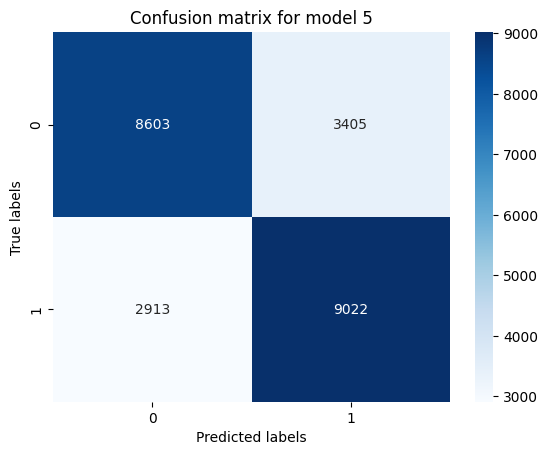

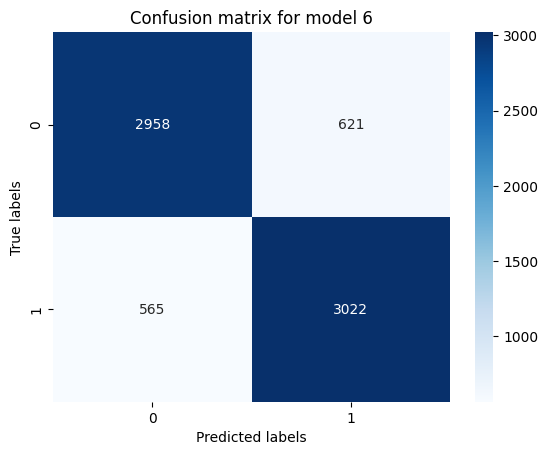

In [83]:
balanced_df1 = balance_classes(transformed_sub_seqs_df1)
balanced_df2 = balance_classes(transformed_sub_seqs_df2)

print(balanced_df1['phrase_end'].value_counts())
print(balanced_df2['phrase_end'].value_counts())

balanced_df_flattened1 = flatten_dataframe(balanced_df1.drop(columns=['phrase_end']))
balanced_df_flattened1['phrase_end'] = balanced_df1['phrase_end']

balanced_df_flattened2 = flatten_dataframe(balanced_df2.drop(columns=['phrase_end']))
balanced_df_flattened2['phrase_end'] = balanced_df2['phrase_end']

X1 = balanced_df_flattened1.drop(columns=['phrase_end'])
y1 = balanced_df_flattened1['phrase_end']

X2 = balanced_df_flattened2.drop(columns=['phrase_end'])
y2 = balanced_df_flattened2['phrase_end']

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.3, random_state=42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3, random_state=42)

pipeline1 = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(**best_params))
])

pipeline1.fit(X_train1, y_train1)
y_pred5 = pipeline1.predict(X_test1)
print("Model 5")
print(classification_report(y_test1, y_pred5))
print(pipeline1.score(X_test1, y_test1))

pipeline2 = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(**best_params))
])

pipeline2.fit(X_train2, y_train2)
y_pred6 = pipeline2.predict(X_test2)
print("Model 6")
print(classification_report(y_test2, y_pred6))
print(pipeline2.score(X_test2, y_test2))

plot_confusion_matrix(y_test1, y_pred5, 'Confusion matrix for model 5')
plot_confusion_matrix(y_test2, y_pred6, 'Confusion matrix for model 6')


Model 5 - any-label - avec scaler - balanced
```
              precision    recall  f1-score   support

           0       0.75      0.76      0.75     12008
           1       0.75      0.74      0.75     11935

    accuracy                           0.75     23943
   macro avg       0.75      0.75      0.75     23943
weighted avg       0.75      0.75      0.75     23943

0.7514513636553481
```
![confusion_matrix](confusion_matrix_for_model_5.png)

Model 6 - end-label - avec scaler - balanced
```
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      3579
           1       0.86      0.87      0.87      3587

    accuracy                           0.87      7166
   macro avg       0.87      0.87      0.87      7166
weighted avg       0.87      0.87      0.87      7166

0.8684063633826402
```
![confusion_matrix](confusion_matrix_for_model_6.png)

résultats plus intéressants avec le balanced, on obtient un meilleur f1-score pour les deux classes. Cependant, le score global est moins bon que si on ne balance pas les classes.

### nouveau gridsearch pour tester mais rien de concluant

In [84]:
from sklearn.model_selection import GridSearchCV
warnings.filterwarnings("ignore")

# balanced_df2 = balance_classes(transformed_sub_seqs_df2)

# balanced_df_flattened2 = flatten_dataframe(balanced_df2.drop(columns=['phrase_end']))
# balanced_df_flattened2['phrase_end'] = balanced_df2['phrase_end']

# X2 = balanced_df_flattened2.drop(columns=['phrase_end'])
# y2 = balanced_df_flattened2['phrase_end']

# X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3, random_state=42)

# pipeline1 = Pipeline([
#     ('scaler', StandardScaler()),
#     ('mlp', MLPClassifier(activation='relu', solver='sgd', alpha=0.0001, learning_rate='constant', max_iter=200))
# ])
# param_grid = {
#     'mlp__activation': ['relu', 'tanh'],
#     'mlp__solver': ['sgd', 'adam'],
#     'mlp__alpha': [0.0001, 0.001, 0.01],
#     'mlp__learning_rate': ['constant', 'adaptive'],
#     'mlp__max_iter': [200, 300, 400]
# }

# grid_search = GridSearchCV(pipeline1, param_grid, cv=5, n_jobs=-1, verbose=2)
# grid_search.fit(X_train2, y_train2)

# print("Best parameters found: ", grid_search.best_params_)
# print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# best_model = grid_search.best_estimator_
# y_pred_best = best_model.predict(X_test2)
# print(classification_report(y_test2, y_pred_best))

In [85]:
# print("Best parameters found: ", grid_search.best_params_)
# print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# best_model = grid_search.best_estimator_
# y_pred_best = best_model.predict(X_test2)
# print(classification_report(y_test2, y_pred_best))

# Nouveau model avec etiqutage hybrid

In [60]:
# Maintenant on ne va considérer comme des fins de phrase que les séquences qui ont une fin de phrase parmi les 3 dernières notes de la séquence
transformed_sub_seqs_df3 = transformed_sub_seqs_df.copy()
transformed_sub_seqs_df3 = transform_target_hybrid(transformed_sub_seqs_df3, 3)

print(transformed_sub_seqs_df1['phrase_end'].value_counts())
print(transformed_sub_seqs_df2['phrase_end'].value_counts())
print(transformed_sub_seqs_df3['phrase_end'].value_counts())


phrase_end
1    67102
0    39905
Name: count, dtype: int64
phrase_end
0    95065
1    11942
Name: count, dtype: int64
phrase_end
0    78204
1    28803
Name: count, dtype: int64


In [61]:
balanced_df3 = balance_classes(transformed_sub_seqs_df3)
balanced_df_flattened3 = flatten_dataframe(balanced_df3.drop(columns=['phrase_end']))
balanced_df_flattened3['phrase_end'] = balanced_df3['phrase_end']

In [88]:
X3 = balanced_df_flattened3.drop(columns=['phrase_end'])
y3 = balanced_df_flattened3['phrase_end']

X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.3, random_state=42)

pipeline3 = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(activation='relu', solver='sgd', alpha=0.0001, learning_rate='constant', max_iter=200))
])

pipeline3.fit(X_train3, y_train3)
y_pred7 = pipeline3.predict(X_test3)
print("Model 7")
print(classification_report(y_test3, y_pred7))
print(pipeline3.score(X_test3, y_test3))

plot_confusion_matrix(y_test3, y_pred7, 'Confusion matrix for model 7')

In [89]:
# Perform cross-validation
cv_scores = cross_val_score(pipeline3, X3, y3, cv=5, scoring='accuracy')

print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

## On va maintenant tester plusieurs longueurs de sous séquences et plusieurs étiquetages

In [48]:
import warnings
warnings.filterwarnings("ignore")

def evaluate_models(lengths, ends, new_df):
    res = []

    for length in lengths:
        for end in ends:
            test = f'length={length}, end={end}'

            sub_seqs_df = generate_subsequences(new_df, length=length)
            transformed_sub_seqs_df = transform_features(sub_seqs_df)
            transformed_sub_seqs_df = transform_target_hybrid(transformed_sub_seqs_df, end)
            balanced_df = balance_classes(transformed_sub_seqs_df)
            balanced_df_flattened = flatten_dataframe(balanced_df.drop(columns=['phrase_end']))
            balanced_df_flattened['phrase_end'] = balanced_df['phrase_end']

            X = balanced_df_flattened.drop(columns=['phrase_end'])
            y = balanced_df_flattened['phrase_end']

            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('mlp', MLPClassifier(activation='relu', solver='sgd', alpha=0.0001, learning_rate='constant', max_iter=200))
            ])

            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_test)
            print(f"Model {test}")
            print("shape : ", balanced_df_flattened.shape)
            classification_rep = classification_report(y_test, y_pred, output_dict=True)
            score = pipeline.score(X_test, y_test)
            print(classification_report(y_test, y_pred))
            print("score : ", score)
            res.append({
                'model': test,
                'classification_report': classification_rep,
                'score': score,
                'length': length,
                'end': end,
                'shape': balanced_df_flattened.shape
            })

            plot_confusion_matrix(y_test, y_pred, f'Confusion matrix for model {test}', display=False)

    return res

Model length=4, end=1
shape :  (44182, 53)
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      6652
           1       0.86      0.85      0.86      6603

    accuracy                           0.86     13255
   macro avg       0.86      0.86      0.86     13255
weighted avg       0.86      0.86      0.86     13255

score :  0.8582421727649944
Model length=4, end=2
shape :  (77026, 53)
              precision    recall  f1-score   support

           0       0.83      0.84      0.84     11535
           1       0.84      0.83      0.83     11573

    accuracy                           0.84     23108
   macro avg       0.84      0.84      0.84     23108
weighted avg       0.84      0.84      0.84     23108

score :  0.8352951358836767
Model length=4, end=3
shape :  (111660, 53)
              precision    recall  f1-score   support

           0       0.80      0.81      0.81     16811
           1       0.81      0.80      0.80     166

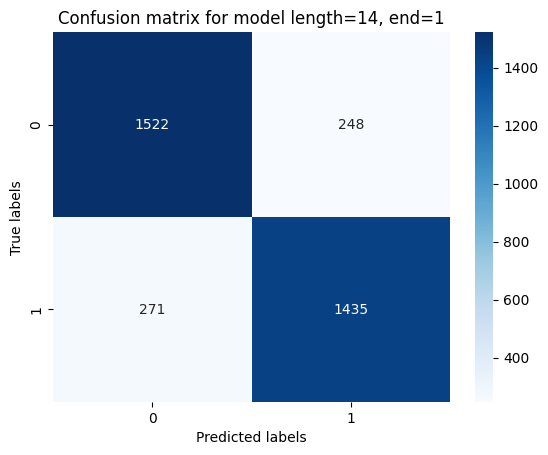

In [50]:
lengths = [4, 6, 8]
ends = [1, 2, 3]

res1 = evaluate_models(lengths, ends, new_df)

lengths = [4, 6, 8, 10, 12, 14]
ends = [1]

res2 = evaluate_models(lengths, ends, new_df)

voir matrice de confusion pour chaque modèle

```
Model length=4, end=1
shape :  (44182, 53)
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      6652
           1       0.86      0.85      0.86      6603

    accuracy                           0.86     13255
   macro avg       0.86      0.86      0.86     13255
weighted avg       0.86      0.86      0.86     13255

score :  0.8575631837042625
Model length=4, end=2
shape :  (77026, 53)
              precision    recall  f1-score   support

           0       0.83      0.85      0.84     11535
           1       0.84      0.83      0.83     11573

    accuracy                           0.84     23108
   macro avg       0.84      0.84      0.84     23108
weighted avg       0.84      0.84      0.84     23108

score :  0.8365068374588887
Model length=4, end=3
shape :  (111660, 53)
              precision    recall  f1-score   support

           0       0.80      0.82      0.81     16811
           1       0.81      0.80      0.80     16687

    accuracy                           0.81     33498
   macro avg       0.81      0.81      0.81     33498
weighted avg       0.81      0.81      0.81     33498

score :  0.8063167950325393
Model length=4, end=4
shape :  (144434, 53)
              precision    recall  f1-score   support

           0       0.78      0.80      0.79     21622
           1       0.79      0.77      0.78     21709

    accuracy                           0.79     43331
   macro avg       0.79      0.79      0.79     43331
weighted avg       0.79      0.79      0.79     43331

score :  0.7856269183725277
Model length=5, end=1
shape :  (32822, 66)
              precision    recall  f1-score   support

           0       0.86      0.87      0.86      4989
           1       0.86      0.85      0.86      4858

    accuracy                           0.86      9847
   macro avg       0.86      0.86      0.86      9847
weighted avg       0.86      0.86      0.86      9847

score :  0.8587387021427846
Model length=5, end=2
shape :  (60044, 66)
              precision    recall  f1-score   support

           0       0.83      0.84      0.84      8948
           1       0.84      0.83      0.84      9066

    accuracy                           0.84     18014
   macro avg       0.84      0.84      0.84     18014
weighted avg       0.84      0.84      0.84     18014

score :  0.8359609192850006
Model length=5, end=3
shape :  (88768, 66)
              precision    recall  f1-score   support

           0       0.80      0.83      0.81     13323
           1       0.82      0.79      0.81     13308

    accuracy                           0.81     26631
   macro avg       0.81      0.81      0.81     26631
weighted avg       0.81      0.81      0.81     26631

score :  0.8103713717096617
Model length=5, end=4
shape :  (115642, 66)
              precision    recall  f1-score   support

           0       0.78      0.80      0.79     17420
           1       0.79      0.78      0.79     17273

    accuracy                           0.79     34693
   macro avg       0.79      0.79      0.79     34693
weighted avg       0.79      0.79      0.79     34693

score :  0.7890064278096446
Model length=6, end=1
shape :  (27148, 79)
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      4054
           1       0.87      0.84      0.86      4091

    accuracy                           0.86      8145
   macro avg       0.86      0.86      0.86      8145
weighted avg       0.86      0.86      0.86      8145

score :  0.8577041129527317
Model length=6, end=2
shape :  (48788, 79)
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      7280
           1       0.85      0.83      0.84      7357

    accuracy                           0.84     14637
   macro avg       0.84      0.84      0.84     14637
weighted avg       0.84      0.84      0.84     14637

score :  0.8370567739290838
Model length=6, end=3
shape :  (72880, 79)
              precision    recall  f1-score   support

           0       0.81      0.83      0.82     10944
           1       0.83      0.81      0.82     10920

    accuracy                           0.82     21864
   macro avg       0.82      0.82      0.82     21864
weighted avg       0.82      0.82      0.82     21864

score :  0.8188346139773143
Model length=6, end=4
shape :  (95522, 79)
              precision    recall  f1-score   support

           0       0.80      0.81      0.80     14370
           1       0.80      0.79      0.80     14287

    accuracy                           0.80     28657
   macro avg       0.80      0.80      0.80     28657
weighted avg       0.80      0.80      0.80     28657

score :  0.7990717800188436
Model length=7, end=1
shape :  (22800, 92)
              precision    recall  f1-score   support

           0       0.86      0.87      0.86      3441
           1       0.87      0.85      0.86      3399

    accuracy                           0.86      6840
   macro avg       0.86      0.86      0.86      6840
weighted avg       0.86      0.86      0.86      6840

score :  0.8625730994152047
Model length=7, end=2
shape :  (41654, 92)
              precision    recall  f1-score   support

           0       0.84      0.85      0.84      6293
           1       0.84      0.83      0.84      6204

    accuracy                           0.84     12497
   macro avg       0.84      0.84      0.84     12497
weighted avg       0.84      0.84      0.84     12497

score :  0.8399615907817877
Model length=7, end=3
shape :  (60366, 92)
              precision    recall  f1-score   support

           0       0.81      0.82      0.82      9021
           1       0.82      0.81      0.82      9089

    accuracy                           0.82     18110
   macro avg       0.82      0.82      0.82     18110
weighted avg       0.82      0.82      0.82     18110

score :  0.8163997791275538
Model length=7, end=4
shape :  (79592, 92)
              precision    recall  f1-score   support

           0       0.80      0.80      0.80     11945
           1       0.80      0.80      0.80     11933

    accuracy                           0.80     23878
   macro avg       0.80      0.80      0.80     23878
weighted avg       0.80      0.80      0.80     23878

score :  0.8017840690175057
Model length=8, end=1
shape :  (23884, 105)
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      3579
           1       0.87      0.87      0.87      3587

    accuracy                           0.87      7166
   macro avg       0.87      0.87      0.87      7166
weighted avg       0.87      0.87      0.87      7166

score :  0.8678481719229696
Model length=8, end=2
shape :  (40552, 105)
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      6100
           1       0.84      0.83      0.84      6066

    accuracy                           0.84     12166
   macro avg       0.84      0.84      0.84     12166
weighted avg       0.84      0.84      0.84     12166

score :  0.838402104224889
Model length=8, end=3
shape :  (57606, 105)
              precision    recall  f1-score   support

           0       0.82      0.82      0.82      8606
           1       0.82      0.82      0.82      8676

    accuracy                           0.82     17282
   macro avg       0.82      0.82      0.82     17282
weighted avg       0.82      0.82      0.82     17282

score :  0.8194074759865756
Model length=8, end=4
shape :  (72860, 105)
              precision    recall  f1-score   support

           0       0.80      0.80      0.80     10947
           1       0.80      0.80      0.80     10911

    accuracy                           0.80     21858
   macro avg       0.80      0.80      0.80     21858
weighted avg       0.80      0.80      0.80     21858

score :  0.799341202305792
Model length=10, end=1
shape :  (17860, 131)
              precision    recall  f1-score   support

           0       0.86      0.87      0.86      2688
           1       0.87      0.85      0.86      2670

    accuracy                           0.86      5358
   macro avg       0.86      0.86      0.86      5358
weighted avg       0.86      0.86      0.86      5358

score :  0.8613288540500187
Model length=10, end=2
shape :  (32084, 131)
              precision    recall  f1-score   support

           0       0.83      0.84      0.84      4864
           1       0.84      0.83      0.83      4762

    accuracy                           0.83      9626
   macro avg       0.83      0.83      0.83      9626
weighted avg       0.83      0.83      0.83      9626

score :  0.8345107001869936
Model length=10, end=3
shape :  (48284, 131)
              precision    recall  f1-score   support

           0       0.80      0.82      0.81      7246
           1       0.81      0.80      0.81      7240

    accuracy                           0.81     14486
   macro avg       0.81      0.81      0.81     14486
weighted avg       0.81      0.81      0.81     14486

score :  0.8093331492475494
Model length=10, end=4
shape :  (61734, 131)
              precision    recall  f1-score   support

           0       0.79      0.81      0.80      9213
           1       0.80      0.79      0.80      9308

    accuracy                           0.80     18521
   macro avg       0.80      0.80      0.80     18521
weighted avg       0.80      0.80      0.80     18521

score :  0.7973111603045192
```


In [62]:
# res1

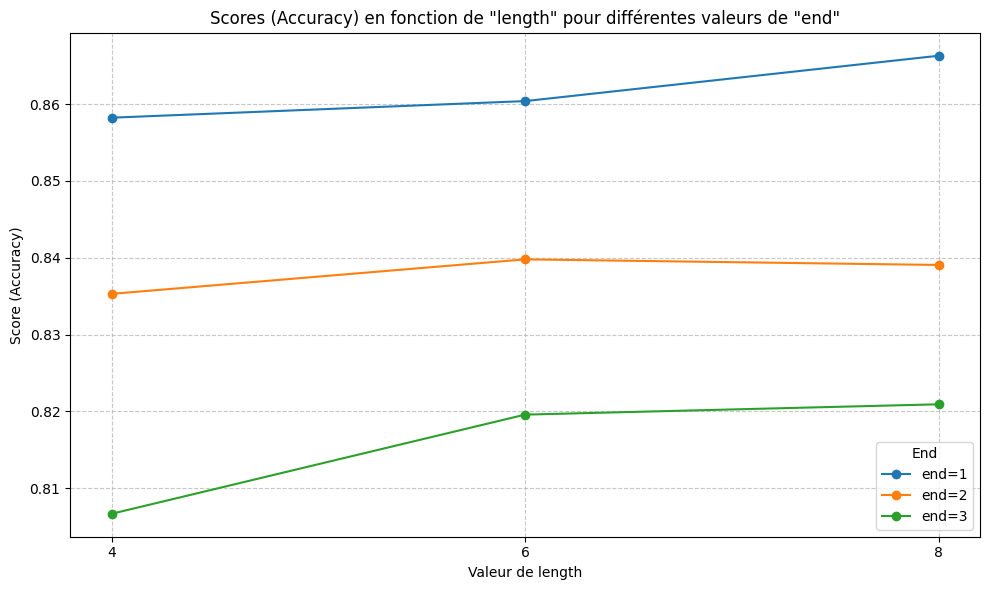

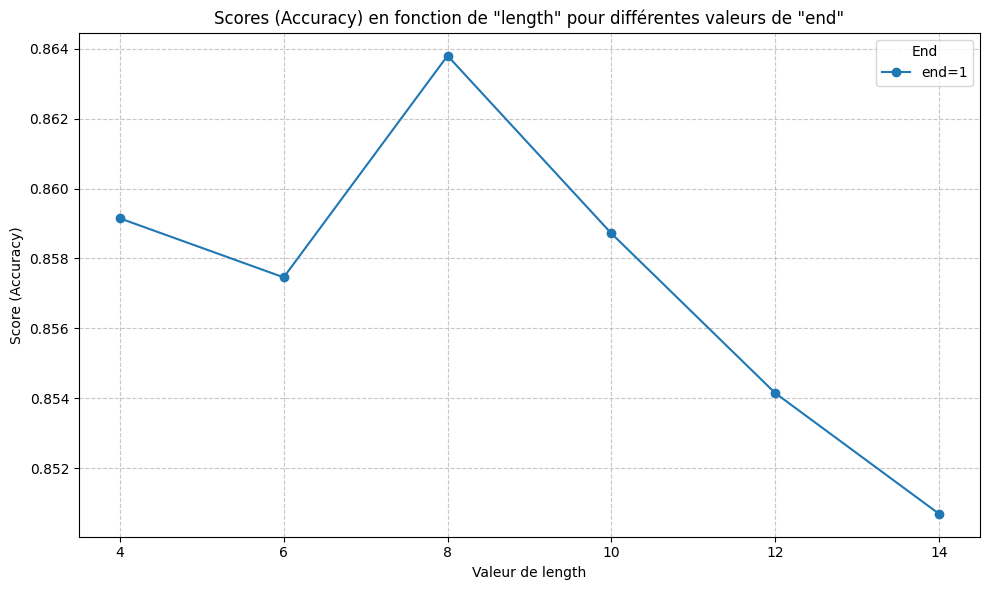

In [52]:
import matplotlib.pyplot as plt

def plot_scores_by_length(data, title):
    """
    Trace un graphique des scores (accuracy) en fonction de 'length' pour différentes valeurs de 'end'.

    :param data: Liste de dictionnaires contenant les informations des modèles.
                 Chaque dictionnaire doit inclure les clés 'length', 'end' et 'score'.
    """
    grouped_data = {}
    for entry in data:
        end = entry['end']
        if end not in grouped_data:
            grouped_data[end] = {'lengths': [], 'scores': []}
        grouped_data[end]['lengths'].append(entry['length'])
        grouped_data[end]['scores'].append(entry['score'])

    plt.figure(figsize=(10, 6))
    for end, values in grouped_data.items():
        plt.plot(values['lengths'], values['scores'], marker='o', linestyle='-', label=f'end={end}')

    plt.title('Scores (Accuracy) en fonction de "length" pour différentes valeurs de "end"')
    plt.xlabel('Valeur de length')
    plt.ylabel('Score (Accuracy)')
    plt.grid(visible=True, linestyle='--', alpha=0.7)
    plt.xticks(sorted(set(entry['length'] for entry in data)))
    plt.legend(title='End', loc='best')
    plt.tight_layout()
    plt.savefig('scores_by_length_'+title+'.png')
    plt.show()

plot_scores_by_length(res1, '1')
plot_scores_by_length(res2, '2')


![](scores_by_length_1.png)
![](scores_by_length_2.png)

Il semblerait que l'étiquetage à la fin de la séquence soit le meilleur, testons plus de longueurs de sous-séquences

Attention à ne pas prendre de sous-séquences trop longues, on pourrait se retrouver avec des phrases entières voir plusieures phrases dans une même sous-séquence ce qui n'a pas trop de sens pour notre modèle car ou veut savoir si un morceau de phrase est une fin de phrase.

## On prend la fin de la séquence plutot que le début afin d'avoir plus d'exemple de classe 1 

On a ajouté un paramètre reverse dans la fonction generate_subsequences pour pouvoir commencer à prendre les sous séquences à la fin car chaque fin de séquences est une fin de phrase. cela permet d'avoir plus d'exemple après le balance_classes dans le cas de l'étiquetage end

In [19]:
sub_seqs_df_normal = generate_subsequences(new_df)
sub_seqs_df_reverse = generate_subsequences(new_df, reverse=True)

transformed_sub_seqs_df_normal = transform_features(sub_seqs_df_normal)
transformed_sub_seqs_df_reverse = transform_features(sub_seqs_df_reverse)

transformed_sub_seqs_df_normal = transform_target_end(transformed_sub_seqs_df_normal)
transformed_sub_seqs_df_reverse = transform_target_end(transformed_sub_seqs_df_reverse)

balanced_df_normal = balance_classes(transformed_sub_seqs_df_normal)
balanced_df_reverse = balance_classes(transformed_sub_seqs_df_reverse)

balanced_df_flattened_normal = flatten_dataframe(balanced_df_normal.drop(columns=['phrase_end']))
balanced_df_flattened_normal['phrase_end'] = balanced_df_normal['phrase_end']

balanced_df_flattened_reverse = flatten_dataframe(balanced_df_reverse.drop(columns=['phrase_end']))
balanced_df_flattened_reverse['phrase_end'] = balanced_df_reverse['phrase_end']

print(balanced_df_flattened_normal['phrase_end'].value_counts())
print(balanced_df_flattened_reverse['phrase_end'].value_counts())

phrase_end
0    11942
1    11942
Name: count, dtype: int64
phrase_end
0    22904
1    22904
Name: count, dtype: int64


Pour une longueur de sous-séquence de 8, on a deux fois plus d'exemples, donc une meilleur chose pour l'apprentissage

Model normal
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      3579
           1       0.83      0.85      0.84      3587

    accuracy                           0.84      7166
   macro avg       0.84      0.84      0.84      7166
weighted avg       0.84      0.84      0.84      7166

0.8372871895060006
Model reverse
              precision    recall  f1-score   support

           0       0.88      0.87      0.87      6910
           1       0.87      0.88      0.87      6833

    accuracy                           0.87     13743
   macro avg       0.87      0.87      0.87     13743
weighted avg       0.87      0.87      0.87     13743

0.8745543185621771


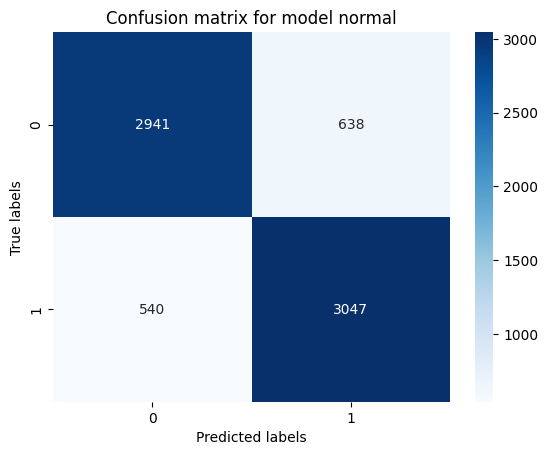

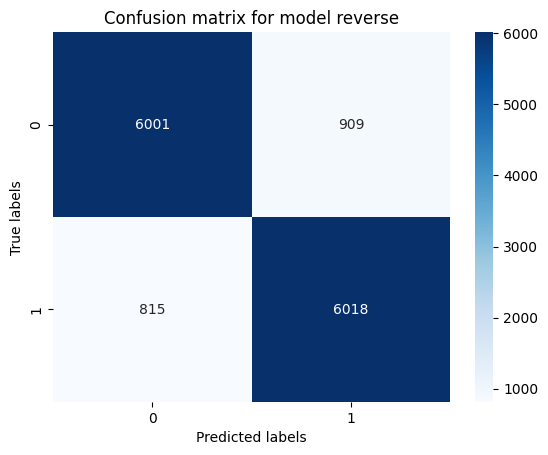

In [95]:
X_normal = balanced_df_flattened_normal.drop(columns=['phrase_end'])
y_normal = balanced_df_flattened_normal['phrase_end']

X_reverse = balanced_df_flattened_reverse.drop(columns=['phrase_end'])
y_reverse = balanced_df_flattened_reverse['phrase_end']

X_train_normal, X_test_normal, y_train_normal, y_test_normal = train_test_split(X_normal, y_normal, test_size=0.3, random_state=42)
X_train_reverse, X_test_reverse, y_train_reverse, y_test_reverse = train_test_split(X_reverse, y_reverse, test_size=0.3, random_state=42)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(**best_params))
])

pipeline.fit(X_train_normal, y_train_normal)
y_pred_normal = pipeline.predict(X_test_normal)

pipeline.fit(X_train_reverse, y_train_reverse)
y_pred_reverse = pipeline.predict(X_test_reverse)

print("Model normal")
print(classification_report(y_test_normal, y_pred_normal))
print(pipeline.score(X_test_normal, y_test_normal))

print("Model reverse")
print(classification_report(y_test_reverse, y_pred_reverse))
print(pipeline.score(X_test_reverse, y_test_reverse))

plot_confusion_matrix(y_test_normal, y_pred_normal, 'Confusion matrix for model normal', display=True)
plot_confusion_matrix(y_test_reverse, y_pred_reverse, 'Confusion matrix for model reverse', display=True)

Model normal
```
              precision    recall  f1-score   support

           0       0.87      0.86      0.86      3579
           1       0.86      0.87      0.87      3587

    accuracy                           0.87      7166
   macro avg       0.87      0.87      0.87      7166
weighted avg       0.87      0.87      0.87      7166

0.8653363103544516
```
![confusion_matrix](confusion_matrix_for_model_normal.png)
Model reverse
```
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      6910
           1       0.91      0.89      0.90      6833

    accuracy                           0.90     13743
   macro avg       0.90      0.90      0.90     13743
weighted avg       0.90      0.90      0.90     13743

0.900676708142327
```
![confusion_matrix](confusion_matrix_for_model_reverse.png)

On peut le voir sur le score qu'avec plus d'exemple notre model devient plus précis

# nouveau test de plusieurs modèle

In [100]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

sub_seqs_df = generate_subsequences(new_df, length=8, reverse=True)
transformed_sub_seqs_df = transform_features(sub_seqs_df)
transformed_sub_seqs_df = transform_target_hybrid(transformed_sub_seqs_df, 1) # équivalent à transform_target_end
balanced_df = balance_classes(transformed_sub_seqs_df)
balanced_df_flattened = flatten_dataframe(balanced_df.drop(columns=['phrase_end']))
balanced_df_flattened['phrase_end'] = balanced_df['phrase_end']
print(balanced_df_flattened.shape)

X = balanced_df_flattened.drop(columns=['phrase_end'])
y = balanced_df_flattened['phrase_end']

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'KNN': KNeighborsClassifier(),
    'MLP': MLPClassifier(**best_params),
    'Naive Bayes': GaussianNB(),
    'Decision Tree' : DecisionTreeClassifier(),
    'SGD' : SGDClassifier()
}

for name, model in models.items():
    pipeline = Pipeline([
        # ('scaler', StandardScaler()),
        ('model', model)
    ])
    scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
    print(f"{name}:")
    print(f"Cross-validation scores: {scores}")
    print(f"Mean cross-validation score: {scores.mean()}")
    print("-" * 30)

# random forest semble être le meilleur


(45808, 105)
Logistic Regression:
Cross-validation scores: [0.89107182 0.88801572 0.88419559 0.88811265 0.88723938]
Mean cross-validation score: 0.8877270323517965
------------------------------
SVM:
Cross-validation scores: [0.82940406 0.83158699 0.82165466 0.82327257 0.82250846]
Mean cross-validation score: 0.8256853477631145
------------------------------
Random Forest:
Cross-validation scores: [0.9117005  0.90940843 0.90755294 0.9095077  0.90492304]
Mean cross-validation score: 0.9086185206448156
------------------------------
KNN:
Cross-validation scores: [0.7552936  0.75191006 0.75725824 0.74511516 0.74838991]
Mean cross-validation score: 0.7515933967490913
------------------------------
MLP:
Cross-validation scores: [0.89718402 0.89292731 0.88648767 0.894553   0.8919332 ]
Mean cross-validation score: 0.8926170374632496
------------------------------
Naive Bayes:
Cross-validation scores: [0.76249727 0.75911373 0.75256494 0.74642506 0.75111887]
Mean cross-validation score: 0.75434

(32492, 235)

Logistic Regression:
Cross-validation scores: [0.92306509 0.92891214 0.9242844  0.92474608 0.92674669]  
Mean cross-validation score: 0.9255508778938977

SVM:
Cross-validation scores: [0.92845053 0.93537467 0.92997845 0.92951677 0.93213296]  
Mean cross-validation score: 0.9310906794335526

Random Forest:
Cross-validation scores: [0.93229728 0.94045238 0.93674977 0.92874731 0.93382579]  
Mean cross-validation score: 0.9344145044735676

KNN:
Cross-validation scores: [0.79904601 0.80150792 0.79347492 0.79870729 0.79716836]  
Mean cross-validation score: 0.7979809001560058

MLP:
Cross-validation scores: [0.92506539 0.93306663 0.92336103 0.92920899 0.92951677]  
Mean cross-validation score: 0.9280437632496057

Naive Bayes:
Cross-validation scores: [0.8052008  0.80443145 0.79285934 0.79270545 0.80440135]  
Mean cross-validation score: 0.7999196789088607

Decision Tree:
Cross-validation scores: [0.88921373 0.89152177 0.8910434  0.888735   0.88734995]  
Mean cross-validation score: 0.8895727689905273

SGD:
Cross-validation scores: [0.899523   0.91660255 0.91151123 0.91812865 0.91982148]  
Mean cross-validation score: 0.9131173861016381


In [101]:
# grid search random forest
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

sub_seqs_df = generate_subsequences(new_df, length=8, reverse=True)
transformed_sub_seqs_df = transform_features(sub_seqs_df)
transformed_sub_seqs_df = transform_target_hybrid(transformed_sub_seqs_df, 1) # équivalent à transform_target_end
balanced_df = balance_classes(transformed_sub_seqs_df)
balanced_df_flattened = flatten_dataframe(balanced_df.drop(columns=['phrase_end']))
balanced_df_flattened['phrase_end'] = balanced_df['phrase_end']
print(balanced_df_flattened.shape)

X = balanced_df_flattened.drop(columns=['phrase_end'])
y = balanced_df_flattened['phrase_end']

param_grid = {
    'model__n_estimators': [100, 300],
    'model__max_depth': [None, 10, 30],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2, 4],
    'model__bootstrap': [True, False]
}

# Create the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(random_state=42)) 
])

# Create the Grid Search object
grid_search = GridSearchCV(estimator=pipeline, 
                          param_grid=param_grid, 
                          cv=5, 
                          scoring='accuracy', 
                          n_jobs=-1, 
                          verbose=2)

# Fit the Grid Search to the data
grid_search.fit(X, y)

# Print the best parameters and score
print("Best parameters found by grid search:", grid_search.best_params_)
print("Best accuracy score:", grid_search.best_score_)

# Evaluate the best model on the data
best_model = grid_search.best_estimator_
scores = cross_val_score(best_model, X, y, cv=4, scoring='accuracy')
print(f"Cross-validation scores with best model: {scores}")
print(f"Mean cross-validation score with best model: {scores.mean()}") 

(45808, 105)
Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END model__bootstrap=True, model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=  25.9s
[CV] END model__bootstrap=True, model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=  26.2s
[CV] END model__bootstrap=True, model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=  26.9s
[CV] END model__bootstrap=True, model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=  27.2s
[CV] END model__bootstrap=True, model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=  28.2s
[CV] END model__bootstrap=True, model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100; total time=  27.1s
[

Best parameters found by grid search: {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 300}  
Best accuracy score: 0.9345992098317941  
Cross-validation scores with best model: [0.93122019 0.94045238 0.9382887  0.93013235 0.93290243]  
Mean cross-validation score with best model: 0.9345992098317941  

On essaye quand même à nouveau un grid search avec MLP car peut être pouvons nous trouver un meilleur score avec d'autres paramètres maintenant que l'on a fait toutes ses modifications sur les données

In [63]:
# grid search MLP
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

sub_seqs_df = generate_subsequences(new_df, length=4, reverse=True)
transformed_sub_seqs_df = transform_features(sub_seqs_df)
transformed_sub_seqs_df = transform_target_hybrid(transformed_sub_seqs_df, 1) # équivalent à transform_target_end
balanced_df = balance_classes(transformed_sub_seqs_df)
balanced_df_flattened = flatten_dataframe(balanced_df.drop(columns=['phrase_end']))
balanced_df_flattened['phrase_end'] = balanced_df['phrase_end']
print(balanced_df_flattened.shape)

X = balanced_df_flattened.drop(columns=['phrase_end'])
y = balanced_df_flattened['phrase_end']

param_grid = {
    'model__hidden_layer_sizes': [(50,50,50), (50,100,50)],
    'model__activation': ['relu'],
    'model__solver': ['sgd', 'adam'],
    'model__alpha': [0.0001, 0.05],
    'model__learning_rate': ['constant','adaptive'],
    'model__max_iter' : [200, 300, 400]
}

# Create the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', MLPClassifier()) 
])

# Create the Grid Search object
grid_search = GridSearchCV(estimator=pipeline, 
                          param_grid=param_grid, 
                          cv=3, 
                          scoring='accuracy', 
                          n_jobs=-1, 
                          verbose=2)

# Fit the Grid Search to the data
grid_search.fit(X, y)

# Print the best parameters and score
print("Best parameters found by grid search:", grid_search.best_params_)
print("Best accuracy score:", grid_search.best_score_)

# Evaluate the best model on the data
best_model = grid_search.best_estimator_
scores = cross_val_score(best_model, X, y, cv=5, scoring='accuracy')
print(f"Cross-validation scores with best model: {scores}")
print(f"Mean cross-validation score with best model: {scores.mean()}") 

(63294, 53)
Fitting 3 folds for each of 48 candidates, totalling 144 fits


/home/gaspar/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END model__activation=relu, model__alpha=0.0001, model__hidden_layer_sizes=(50, 50, 50), model__learning_rate=constant, model__max_iter=200, model__solver=sgd; total time= 3.1min


/home/gaspar/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END model__activation=relu, model__alpha=0.0001, model__hidden_layer_sizes=(50, 50, 50), model__learning_rate=constant, model__max_iter=200, model__solver=sgd; total time= 3.1min


/home/gaspar/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END model__activation=relu, model__alpha=0.0001, model__hidden_layer_sizes=(50, 50, 50), model__learning_rate=constant, model__max_iter=200, model__solver=sgd; total time= 3.1min


/home/gaspar/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END model__activation=relu, model__alpha=0.0001, model__hidden_layer_sizes=(50, 50, 50), model__learning_rate=constant, model__max_iter=200, model__solver=adam; total time= 3.2min


/home/gaspar/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END model__activation=relu, model__alpha=0.0001, model__hidden_layer_sizes=(50, 50, 50), model__learning_rate=constant, model__max_iter=200, model__solver=adam; total time= 3.2min


/home/gaspar/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END model__activation=relu, model__alpha=0.0001, model__hidden_layer_sizes=(50, 50, 50), model__learning_rate=constant, model__max_iter=200, model__solver=adam; total time= 3.2min


/home/gaspar/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END model__activation=relu, model__alpha=0.0001, model__hidden_layer_sizes=(50, 50, 50), model__learning_rate=constant, model__max_iter=300, model__solver=sgd; total time= 4.7min


/home/gaspar/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END model__activation=relu, model__alpha=0.0001, model__hidden_layer_sizes=(50, 50, 50), model__learning_rate=constant, model__max_iter=300, model__solver=sgd; total time= 4.7min


/home/gaspar/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END model__activation=relu, model__alpha=0.0001, model__hidden_layer_sizes=(50, 50, 50), model__learning_rate=constant, model__max_iter=300, model__solver=sgd; total time= 5.3min


/home/gaspar/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END model__activation=relu, model__alpha=0.0001, model__hidden_layer_sizes=(50, 50, 50), model__learning_rate=constant, model__max_iter=300, model__solver=adam; total time= 5.8min
[CV] END model__activation=relu, model__alpha=0.0001, model__hidden_layer_sizes=(50, 50, 50), model__learning_rate=constant, model__max_iter=300, model__solver=adam; total time= 5.8min


/home/gaspar/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END model__activation=relu, model__alpha=0.0001, model__hidden_layer_sizes=(50, 50, 50), model__learning_rate=constant, model__max_iter=300, model__solver=adam; total time= 5.9min


/home/gaspar/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END model__activation=relu, model__alpha=0.0001, model__hidden_layer_sizes=(50, 50, 50), model__learning_rate=constant, model__max_iter=400, model__solver=sgd; total time= 7.2min


/home/gaspar/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END model__activation=relu, model__alpha=0.0001, model__hidden_layer_sizes=(50, 50, 50), model__learning_rate=constant, model__max_iter=400, model__solver=sgd; total time= 7.3min
[CV] END model__activation=relu, model__alpha=0.0001, model__hidden_layer_sizes=(50, 50, 50), model__learning_rate=constant, model__max_iter=400, model__solver=adam; total time= 6.1min


/home/gaspar/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END model__activation=relu, model__alpha=0.0001, model__hidden_layer_sizes=(50, 50, 50), model__learning_rate=constant, model__max_iter=400, model__solver=sgd; total time= 7.4min


/home/gaspar/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END model__activation=relu, model__alpha=0.0001, model__hidden_layer_sizes=(50, 50, 50), model__learning_rate=adaptive, model__max_iter=200, model__solver=sgd; total time= 3.6min


/home/gaspar/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END model__activation=relu, model__alpha=0.0001, model__hidden_layer_sizes=(50, 50, 50), model__learning_rate=adaptive, model__max_iter=200, model__solver=sgd; total time= 3.7min


/home/gaspar/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END model__activation=relu, model__alpha=0.0001, model__hidden_layer_sizes=(50, 50, 50), model__learning_rate=adaptive, model__max_iter=200, model__solver=sgd; total time= 3.8min
[CV] END model__activation=relu, model__alpha=0.0001, model__hidden_layer_sizes=(50, 50, 50), model__learning_rate=constant, model__max_iter=400, model__solver=adam; total time= 6.1min


/home/gaspar/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END model__activation=relu, model__alpha=0.0001, model__hidden_layer_sizes=(50, 50, 50), model__learning_rate=adaptive, model__max_iter=200, model__solver=adam; total time= 4.2min
[CV] END model__activation=relu, model__alpha=0.0001, model__hidden_layer_sizes=(50, 50, 50), model__learning_rate=constant, model__max_iter=400, model__solver=adam; total time= 5.9min


/home/gaspar/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END model__activation=relu, model__alpha=0.0001, model__hidden_layer_sizes=(50, 50, 50), model__learning_rate=adaptive, model__max_iter=200, model__solver=adam; total time= 4.1min


KeyboardInterrupt: 